## Setup
# CNN Cifar 2

In [1]:
##
## Restrict tensorflow to single GPU
##
import os 
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(3)           
## this says only use GPU 0  (can select 0-3)

##
## Import libraries
##
import evm_flat         ## We are using EVMs for a different project, so there are some things in here that may be confusing
from utils import *     ## utils holds a few functions I wrote to help with the experiments in this notebook
import numpy as np
import tensorflow as tf

##
## Experiment Parameters
##
epochs = 10                 ## Iterations to train CNN for feature extractors
num_to_remove = 2           ## Number of classes to remove and make "unknown"
iterations = 30              ## Number of iterations (full experiments) to run
thresholds = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]  ## Confidence thresholds to evaluate over

##
## EVM Parameters (good initial values, but could be further optimized)
##
tailsize = 10000              ## EVM tail size
cover_threshold = 0.5      ## EVM cover threshold
dist_func = 'cosine'     ## EVM distance function
num_to_fuse = 4             ## EVM number to fuse
margin_scale = 0.5          ## EVM margin scale

## Data

In [2]:
##
## Load CiFar10
##
import keras
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

##
## Get data in correct shape and normalize
##
#x_train = x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))/255.0   ## Add dimension and normalize
#x_test = x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))/255.0         ## Add dimension and normalize
#y_train = tf.keras.utils.to_categorical(y_train)     ## Make one-hot
#y_test = tf.keras.utils.to_categorical(y_test)       ## Make one-hot

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
import keras.utils
y_train = tf.keras.utils.to_categorical(y_train) 
y_test = tf.keras.utils.to_categorical(y_test) 

## Create Feature Extractor With Perfect Knowledge 

- Feature extractor is a CNN trained using ALL of the classes
- This is not realistic in the real world because all of the classes will not be known
- This is a good "optimal" feature space to compare against
- Goal would be to get as close to this performance as possible

In [5]:
##
## Perfect Knowledge feature extractor
##
perfect = feature_model2(10, x_train, y_train, x_test, y_test)   ## This function is defined in utils.py

313/313 [==============================] - 1s 3ms/step - loss: 0.9029 - accuracy: 0.6807
[0.9028898477554321, 0.6807000041007996]


## Define a set of experiments

- Randomly select and remove classes from the training data
- Split test data into known and unknown classes
- Fit imperfect feature extraction model
- Extract features using the perfect and imperfect extractors
- Fit EVM using features for the perfect and imperfect
- Evaluate performance (evaluation metrics may need to be improved, but this gives us an initial idea of performance)
- Repeat


In [6]:
import pandas as pd
##
## Define places to store results
##
imp_known_correct_all = []
imp_known_novel_all = []
imp_unknown_correct_all = []
imp_unknown_novel_all = []
per_known_correct_all = []
per_known_novel_all = []
per_unknown_correct_all = []
per_unknown_novel_all = []


df = pd.DataFrame(columns=['Iteration', 'Unknown Classes', 'imp_known_correct_all', 'imp_known_novel_all', 'imp_unknown_novel_all','per_known_correct_all','per_known_novel_all','per_unknown_novel_all'])

##
## Begin experiments
##
for i in range(iterations):
    print('Iteration: ' + str(i))
    print()
    
    ##
    ## Split the data into known and unknown classes
    ##
    toRemove = np.random.choice(10, num_to_remove, replace = False)                                         ## Randomly pick unknown classes
    x_train_known, x_train_unknown, y_train_known, y_train_unknown = split_data(x_train, y_train, toRemove) ## Split train data (defined in utils.py)
    x_test_known, x_test_unknown, y_test_known, y_test_unknown = split_data(x_test, y_test, toRemove)       ## Split test data (defined in utils.py)

    print(x_train_known.shape)
    print(y_train_known.shape)
    print(x_test_known.shape)
    print(y_test_known.shape)
    
    ##
    ## Train a classifier based feature extractor using only the known classes
    ##
    #y_train_known = tf.keras.utils.to_categorical(y_train_known) 
    #y_test_known = tf.keras.utils.to_categorical(y_test_known) 
    
    print(x_train_known.shape)
    print(y_train_known.shape)
    print(x_test_known.shape)
    print(y_test_known.shape)
    
    y_train_known = np.squeeze(y_train_known)
    print(y_train_known.shape)
    imperfect = feature_model2(10-num_to_remove, x_train_known, y_train_known, x_test_known, y_test_known, epochs = epochs, batch_size = 32, verbose = 0)

    ##
    ## Extract features with imperfect extractor
    ##
    x_train_known_imp = imperfect.predict(x_train_known)
    x_test_known_imp = imperfect.predict(x_test_known)
    x_test_unknown_imp = imperfect.predict(x_test_unknown)

    ##
    ## Extract features with perfect extractor
    ##
    x_train_known_per = perfect.predict(x_train_known)
    x_test_known_per = perfect.predict(x_test_known)
    x_test_unknown_per = perfect.predict(x_test_unknown)

    ##
    ## Fit EVMs
    ##
    evm_options = evm_flat.EVMOptions(tailsize = tailsize, cover_threshold = cover_threshold , dist_func = dist_func, num_to_fuse = num_to_fuse, margin_scale = margin_scale)
    
    print('Fit Imperfect EVM')
    evm_imp = evm_flat.ExtremeValueMachine('imperfect', evm_options)
    print(x_train_known_imp.shape)
    print(y_train_known.shape)
    evm_imp.train(x_train_known_imp, y_train_known)
    print('Fit Perfect EVM')
    evm_per = evm_flat.ExtremeValueMachine('perfect', evm_options)
    evm_per.train(x_train_known_per, y_train_known)

    ##
    ## Make Predictions with EVM
    ##
    imp_pred_known = evm_imp.confidence(x_test_known_imp)
    imp_pred_unknown = evm_imp.confidence(x_test_unknown_imp)
    per_pred_known = evm_per.confidence(x_test_known_per)
    per_pred_unknown = evm_per.confidence(x_test_unknown_per)

    ##
    ## Evaluate Predictions
    ##
    imp_known_correct, imp_known_novel = eval(imp_pred_known, y_test_known, thresholds)           ## eval defined in utils.py
    imp_unknown_correct, imp_unknown_novel = eval(imp_pred_unknown, y_test_unknown, thresholds)
    per_known_correct, per_known_novel = eval(per_pred_known, y_test_known, thresholds)
    per_unknown_correct, per_unknown_novel = eval(per_pred_unknown, y_test_unknown, thresholds)
    
    ##
    ## Store results
    ##
    imp_known_correct_all.append(imp_known_correct)      ## imp_known_correct: correct classification percentage of known instances by the imperfect EVM (instances called novel not considered)
    imp_known_novel_all.append(imp_known_novel)          ## imp_known_novel: percentage of known instances called novel by the imperfect EVM 
    imp_unknown_novel_all.append(imp_unknown_novel)      ## imp_unknown_novel: percentage of unknown instances called novel by the imperfect EVM
    per_known_correct_all.append(per_known_correct)      ## per_known_correct: correct classification percentage of known instances by the perfect EVM (instances called novel not considered)
    per_known_novel_all.append(per_known_novel)          ## per_known_novel: percentage of known instances called novel by the perfect EVM
    per_unknown_novel_all.append(per_unknown_novel)      ## per_unknown_novel: percentage of unknown instances called novel by the perfect EVM
    if i <= 5:
        df = df.append({'Iteration':i, 'Unknown Classes': toRemove, 'imp_known_correct_all':imp_known_correct_all, 'imp_known_novel_all':imp_known_novel_all, 'imp_unknown_novel_all':imp_unknown_novel_all,'per_known_correct_all':per_known_correct_all,'per_known_novel_all':per_known_novel_all,'per_unknown_novel_all':per_unknown_novel_all}, ignore_index=True)
        df.to_csv(r'./cnn_df_cf2_five_iter(s).csv', index= False,header=True)
        df.to_csv(r'./cnn_df_cf2.csv', index= False,header=True)
    else:
        df = df.append({'Iteration':i, 'Unknown Classes': toRemove, 'imp_known_correct_all':imp_known_correct_all, 'imp_known_novel_all':imp_known_novel_all, 'imp_unknown_novel_all':imp_unknown_novel_all,'per_known_correct_all':per_known_correct_all,'per_known_novel_all':per_known_novel_all,'per_unknown_novel_all':per_unknown_novel_all}, ignore_index=True)
        df.to_csv(r'./cnn_df_cf2.csv', index= False,header=True)

Iteration: 0

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 2ms/step - loss: 0.8298 - accuracy: 0.6871
[0.8298282623291016, 0.687125027179718]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 1

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 2ms/step - loss: 0.7130 - accuracy: 0.7401
[0.7130224108695984, 0.7401250004768372]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 2

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.7498 - accuracy: 0.7290
[0.7497632503509521, 0.7289999723434448]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 3

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.7945 - accuracy: 0.7149
[0.7944516539573669, 0.7148749828338623]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 4

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 2ms/step - loss: 0.8115 - accuracy: 0.7020
[0.8115034699440002, 0.7020000219345093]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 5

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 2ms/step - loss: 0.6881 - accuracy: 0.7404
[0.6880710124969482, 0.7403749823570251]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 6

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.8909 - accuracy: 0.6817
[0.8909487128257751, 0.6817499995231628]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 7

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 2ms/step - loss: 0.7829 - accuracy: 0.7119
[0.7829366326332092, 0.7118750214576721]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 8

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 2ms/step - loss: 0.6542 - accuracy: 0.7614
[0.6542364954948425, 0.7613750100135803]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 9

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.6870 - accuracy: 0.7599
[0.6869717836380005, 0.7598749995231628]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 10

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 2ms/step - loss: 0.7350 - accuracy: 0.7325
[0.7349575161933899, 0.7325000166893005]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 11

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.8070 - accuracy: 0.6984
[0.8070079684257507, 0.6983749866485596]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 12

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 2ms/step - loss: 0.7635 - accuracy: 0.7246
[0.7635262608528137, 0.7246249914169312]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 13

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.9288 - accuracy: 0.6610
[0.9287693500518799, 0.6610000133514404]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 14

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.7433 - accuracy: 0.7272
[0.7432759404182434, 0.7272499799728394]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 15

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.8546 - accuracy: 0.6842
[0.8546159267425537, 0.684249997138977]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 16

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.7637 - accuracy: 0.7236
[0.763650119304657, 0.7236250042915344]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 17

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.7906 - accuracy: 0.7117
[0.7906221747398376, 0.7117499709129333]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 18

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.9522 - accuracy: 0.6532
[0.9521512389183044, 0.653249979019165]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 19

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.6484 - accuracy: 0.7688
[0.6483741402626038, 0.768750011920929]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 20

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.5810 - accuracy: 0.7946
[0.5810049176216125, 0.7946249842643738]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 21

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.7322 - accuracy: 0.7389
[0.732227087020874, 0.7388749718666077]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 22

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.8149 - accuracy: 0.7061
[0.814925491809845, 0.706125020980835]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 23

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.6999 - accuracy: 0.7465
[0.6999437808990479, 0.7465000152587891]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 24

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.8767 - accuracy: 0.6779
[0.8766806721687317, 0.6778749823570251]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 25

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.8654 - accuracy: 0.6825
[0.8653954267501831, 0.6825000047683716]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 26

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.8911 - accuracy: 0.6722
[0.8910595178604126, 0.672249972820282]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 27

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.7614 - accuracy: 0.7319
[0.761444628238678, 0.7318750023841858]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 28

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.8179 - accuracy: 0.6954
[0.8179044127464294, 0.6953750252723694]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


Iteration: 29

(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 32, 32, 3)
(40000, 8)
(8000, 32, 32, 3)
(8000, 8)
(40000, 8)
250/250 [==============================] - 1s 3ms/step - loss: 0.7326 - accuracy: 0.7379
[0.7325603365898132, 0.7378749847412109]
Fit Imperfect EVM
(40000, 128)
(40000, 8)
Fit Perfect EVM


/home/hardyc/Documents/CiFar-2 Iterations/Walter CNN/utils.py:173: RuntimeWarning: invalid value encountered in long_scalars
  correct = np.sum(pred[con>=i] == truth[con>=i])/np.sum(con>=i)


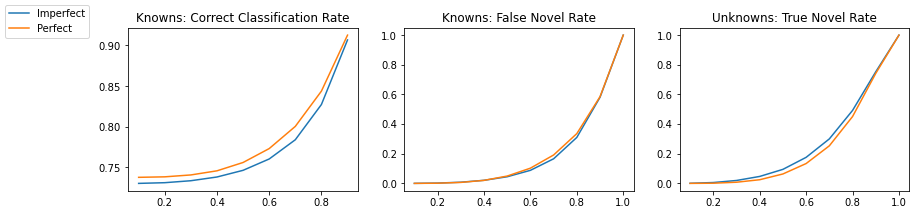

In [8]:
import matplotlib.pyplot as plt



fig = plt.figure(figsize = (14, 3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.title.set_text('Knowns: Correct Classification Rate')
ax2.title.set_text('Knowns: False Novel Rate')
ax3.title.set_text('Unknowns: True Novel Rate')

ax1.plot(thresholds, np.mean(imp_known_correct_all, axis = 0), label = 'Imperfect')
ax1.plot(thresholds, np.mean(per_known_correct_all, axis = 0), label = 'Perfect')


ax2.plot(thresholds, np.mean(imp_known_novel_all, axis = 0), label = 'Imperfect')
ax2.plot(thresholds, np.mean(per_known_novel_all, axis = 0), label = 'Perfect')

ax3.plot(thresholds, np.mean(imp_unknown_novel_all, axis = 0), label = 'Imperfect')
ax3.plot(thresholds, np.mean(per_unknown_novel_all, axis = 0), label = 'Perfect')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')

plt.savefig('CNN_images_cf2_30iter.pdf')
plt.show()